## Data loading

In [1]:
# ============================================================
# 0) INSTALL + IMPORT
# ============================================================
!pip -q install kagglehub

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, roc_auc_score, accuracy_score
)
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)
tf.random.set_seed(42)

print("OK: library siap")


OK: library siap


In [2]:
# ============================================================
# 1) DOWNLOAD DATASET (NASA CMAPSS) VIA KAGGLEHUB
# ============================================================
import kagglehub
DATA_DIR = kagglehub.dataset_download("behrad3d/nasa-cmaps")
print("DATA_DIR:", DATA_DIR)

def find_file(root_dir, filename):
    for root, _, files in os.walk(root_dir):
        if filename in files:
            return os.path.join(root, filename)
    return None

FD = "FD003"
train_fp = find_file(DATA_DIR, f"train_{FD}.txt")
test_fp  = find_file(DATA_DIR, f"test_{FD}.txt")
rul_fp   = find_file(DATA_DIR, f"RUL_{FD}.txt")

print("train_fp:", train_fp)
print("test_fp :", test_fp)
print("rul_fp  :", rul_fp)

if not all([train_fp, test_fp, rul_fp]):
    raise FileNotFoundError("File train/test/RUL tidak ketemu. Cek isi folder DATA_DIR.")


Using Colab cache for faster access to the 'nasa-cmaps' dataset.
DATA_DIR: /kaggle/input/nasa-cmaps
train_fp: /kaggle/input/nasa-cmaps/CMaps/train_FD003.txt
test_fp : /kaggle/input/nasa-cmaps/CMaps/test_FD003.txt
rul_fp  : /kaggle/input/nasa-cmaps/CMaps/RUL_FD003.txt


In [3]:
# ============================================================
# 2) LOAD DATA + SET COLUMN NAMES
# ============================================================
index_names   = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names  = [f's_{i}' for i in range(1, 22)]
col_names     = index_names + setting_names + sensor_names

train_df = pd.read_csv(train_fp, sep=r'\s+', header=None, names=col_names)
test_df  = pd.read_csv(test_fp,  sep=r'\s+', header=None, names=col_names)
rul_df   = pd.read_csv(rul_fp,   sep=r'\s+', header=None, names=['RUL'])

print("Train:", train_df.shape, "Test:", test_df.shape, "RUL:", rul_df.shape)
train_df.head()


Train: (24720, 26) Test: (16596, 26) RUL: (100, 1)


,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


In [4]:
# ============================================================
# 3) HITUNG RUL + LABELING (ANOMALI = RUL <= THRESHOLD)
# ============================================================
THRESHOLD = 30

# ---- TRAIN: RUL = max_cycle(unit) - time_cycles
max_cycle = train_df.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_nr', 'max_cycle']
train_df = train_df.merge(max_cycle, on='unit_nr', how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['time_cycles']
train_df.drop('max_cycle', axis=1, inplace=True)
train_df['label'] = (train_df['RUL'] <= THRESHOLD).astype(int)

# ---- TEST: pakai true RUL per unit dari file RUL_*.txt
max_cycle_test = test_df.groupby('unit_nr')['time_cycles'].max().reset_index()
max_cycle_test.columns = ['unit_nr', 'max_cycle']
test_df = test_df.merge(max_cycle_test, on='unit_nr', how='left')

rul_df['unit_nr'] = rul_df.index + 1
test_df = test_df.merge(rul_df, on='unit_nr', how='left')

# RUL saat ini = true_RUL + (max_cycle_test - time_cycles)
test_df['RUL_calc'] = test_df['RUL'] + (test_df['max_cycle'] - test_df['time_cycles'])
test_df['label'] = (test_df['RUL_calc'] <= THRESHOLD).astype(int)

print("Distribusi label TRAIN:\n", train_df['label'].value_counts())
print("Distribusi label TEST (timestep-level):\n", test_df['label'].value_counts())


Distribusi label TRAIN:
 label
0    21620
1     3100
Name: count, dtype: int64
Distribusi label TEST (timestep-level):
 label
0    16305
1      291
Name: count, dtype: int64


In [5]:
# ============================================================
# 4) NORMALISASI FITUR
# ============================================================
feature_cols = setting_names + sensor_names

scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
test_df[feature_cols]  = scaler.transform(test_df[feature_cols])

print("OK: normalisasi selesai")


OK: normalisasi selesai


In [6]:
# ============================================================
# 5) WINDOWING SEQUENCE PER UNIT (TRAIN MANY WINDOWS, TEST LAST WINDOW PER UNIT)
# ============================================================
SEQUENCE_LENGTH = 80

def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    n = data_matrix.shape[0]
    for start in range(0, n - seq_length):
        stop = start + seq_length
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label_col='label'):
    # label untuk setiap window = label pada titik setelah window (sesuai contohmu)
    labels = id_df[[label_col]].values
    n = labels.shape[0]
    return labels[seq_length:n].astype(int).flatten()

# ---- TRAIN windows
X_train, y_train = [], []
for unit in train_df['unit_nr'].unique():
    unit_df = train_df[train_df['unit_nr'] == unit]
    for seq in gen_sequence(unit_df, SEQUENCE_LENGTH, feature_cols):
        X_train.append(seq)
    y_train.extend(gen_labels(unit_df, SEQUENCE_LENGTH, 'label'))

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.int32)

print("X_train:", X_train.shape, "y_train:", y_train.shape, "rate:", y_train.mean())

# ---- TEST: ambil LAST window per unit (lebih sederhana untuk demo)
X_test, y_test = [], []
for unit in test_df['unit_nr'].unique():
    unit_df = test_df[test_df['unit_nr'] == unit]
    if len(unit_df) >= SEQUENCE_LENGTH:
        X_test.append(unit_df[feature_cols].values[-SEQUENCE_LENGTH:])
        y_test.append(int(unit_df['label'].iloc[-1]))

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.int32)

print("X_test:", X_test.shape, "y_test:", y_test.shape, "rate:", y_test.mean())


X_train: (16720, 80, 24) y_train: (16720,) rate: 0.1854066985645933
X_test: (86, 80, 24) y_test: (86,) rate: 0.23255813953488372


In [7]:
def build_cnn_lstm(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        LSTM(64),
        Dropout(0.2),

        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
    )
    return model

model = build_cnn_lstm((X_train.shape[1], X_train.shape[2]))
model.summary()

early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True)
ckpt = ModelCheckpoint("best_cnn_lstm.keras", monitor="val_auc", mode="max", save_best_only=True)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, ckpt],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 78, 64)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 39, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,809 (155.50 KB)

 Trainable params: 39,809 (155.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.8467 - auc: 0.8026 - loss: 0.3553 - val_accuracy: 0.9638 - val_auc: 0.9911 - val_loss: 0.1072
Epoch 2/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9457 - auc: 0.9818 - loss: 0.1306 - val_accuracy: 0.9632 - val_auc: 0.9922 - val_loss: 0.0929
Epoch 3/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9559 - auc: 0.9874 - loss: 0.1111 - val_accuracy: 0.9644 - val_auc: 0.9943 - val_loss: 0.0815
Epoch 4/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9622 - auc: 0.9916 - loss: 0.0914 - val_accuracy: 0.9713 - val_auc: 0.9958 - val_loss: 0.0710
Epoch 5/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9630 - auc: 0.9920 - loss: 0.0890 - val_accuracy: 0.9692 - val_auc: 0.9961 - val_loss: 0.0695
Epoch 6/50
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9668 - auc: 0.9935 - loss: 0.0804 - val_accuracy: 0.9698 - val_auc: 0.9964 - val_loss: 0.0667
Epoch 7/50
209/209 ━━━━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
=== CNN-LSTM Evaluation ===
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98        66
     Anomali       0.95      0.95      0.95        20

    accuracy                           0.98        86
   macro avg       0.97      0.97      0.97        86
weighted avg       0.98      0.98      0.98        86

Accuracy: 0.9767441860465116


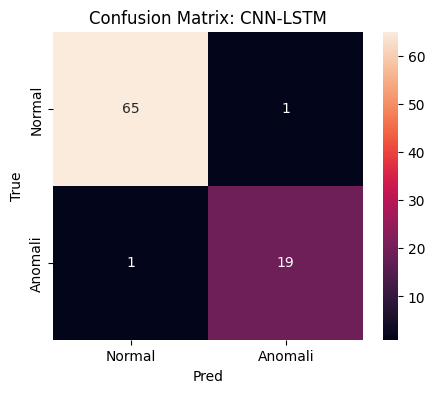

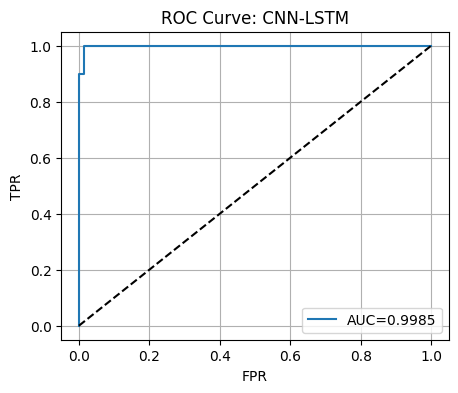

AUC: 0.9984848484848485


In [8]:
best_model = tf.keras.models.load_model("best_cnn_lstm.keras")

y_prob = best_model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("=== CNN-LSTM Evaluation ===")
print(classification_report(y_test, y_pred, target_names=['Normal','Anomali']))
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Normal','Anomali'],
            yticklabels=['Normal','Anomali'])
plt.title("Confusion Matrix: CNN-LSTM")
plt.xlabel("Pred"); plt.ylabel("True")
plt.show()

auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve: CNN-LSTM")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.grid(True)
plt.show()

print("AUC:", auc)


In [9]:
from sklearn.model_selection import train_test_split

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print("Train split:", X_tr.shape, np.bincount(y_tr))
print("Val   split:", X_val.shape, np.bincount(y_val))


Train split: (13376, 80, 24) [10896  2480]
Val   split: (3344, 80, 24) [2724  620]


In [10]:
import numpy as np, random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_cnn_lstm_hp(input_shape,
                      filters=64,
                      kernel_size=3,
                      lstm_units=64,
                      dropout=0.2,
                      dense_units=32,
                      lr=1e-3):
    model = Sequential([
        Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(dropout),

        LSTM(lstm_units),
        Dropout(dropout),

        Dense(dense_units, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name="auc")]
    )
    return model

search_space = {
    "filters":     [32, 64, 128],
    "kernel_size": [3, 5, 7],
    "lstm_units":  [32, 64, 128],
    "dropout":     [0.2, 0.3, 0.4],
    "dense_units": [16, 32, 64],
    "lr":          [1e-3, 5e-4, 1e-4],
}

def sample_params(space):
    return {k: random.choice(v) for k, v in space.items()}

N_TRIALS = 12
EPOCHS_SEARCH = 25
BATCH_SIZE = 64

best_auc = -1
best_params = None

input_shape = (X_train.shape[1], X_train.shape[2])

for t in range(1, N_TRIALS + 1):
    params = sample_params(search_space)
    print(f"\n[TRIAL {t}/{N_TRIALS}] params={params}")

    model = build_cnn_lstm_hp(input_shape, **params)

    es = EarlyStopping(monitor="val_auc", mode="max", patience=4, restore_best_weights=True)
    ckpt = ModelCheckpoint(
        f"trial_{t:02d}_best.keras",
        monitor="val_auc", mode="max",
        save_best_only=True, verbose=0
    )

    hist = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=EPOCHS_SEARCH,
        batch_size=BATCH_SIZE,
        callbacks=[es, ckpt],
        verbose=0
    )

    trial_best = float(np.max(hist.history["val_auc"]))
    print("best val_auc:", round(trial_best, 4))

    if trial_best > best_auc:
        best_auc = trial_best
        best_params = params
        best_trial_file = f"trial_{t:02d}_best.keras"
        print(">>> BEST UPDATED:", best_trial_file)

print("\n=== BEST RESULT ===")
print("best_params:", best_params)
print("best_val_auc:", round(best_auc, 4))
print("best_model_file:", best_trial_file)



[TRIAL 1/12] params={'filters': 32, 'kernel_size': 5, 'lstm_units': 128, 'dropout': 0.2, 'dense_units': 32, 'lr': 0.0001}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


best val_auc: 0.996
>>> BEST UPDATED: trial_01_best.keras

[TRIAL 2/12] params={'filters': 64, 'kernel_size': 7, 'lstm_units': 32, 'dropout': 0.4, 'dense_units': 32, 'lr': 0.0005}
best val_auc: 0.9977
>>> BEST UPDATED: trial_02_best.keras

[TRIAL 3/12] params={'filters': 32, 'kernel_size': 3, 'lstm_units': 32, 'dropout': 0.4, 'dense_units': 16, 'lr': 0.0001}
best val_auc: 0.9953

[TRIAL 4/12] params={'filters': 32, 'kernel_size': 7, 'lstm_units': 128, 'dropout': 0.2, 'dense_units': 16, 'lr': 0.001}
best val_auc: 0.9971

[TRIAL 5/12] params={'filters': 128, 'kernel_size': 5, 'lstm_units': 32, 'dropout': 0.3, 'dense_units': 64, 'lr': 0.0005}
best val_auc: 0.9976

[TRIAL 6/12] params={'filters': 32, 'kernel_size': 3, 'lstm_units': 128, 'dropout': 0.4, 'dense_units': 32, 'lr': 0.001}
best val_auc: 0.9968

[TRIAL 7/12] params={'filters': 64, 'kernel_size': 7, 'lstm_units': 64, 'dropout': 0.4, 'dense_units': 16, 'lr': 0.0005}
best val_auc: 0.9974

[TRIAL 8/12] params={'filters': 128, 'kernel

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
=== CNN-LSTM Evaluation (Tuned) ===
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98        66
     Anomali       0.95      0.95      0.95        20

    accuracy                           0.98        86
   macro avg       0.97      0.97      0.97        86
weighted avg       0.98      0.98      0.98        86

Accuracy: 0.9767441860465116


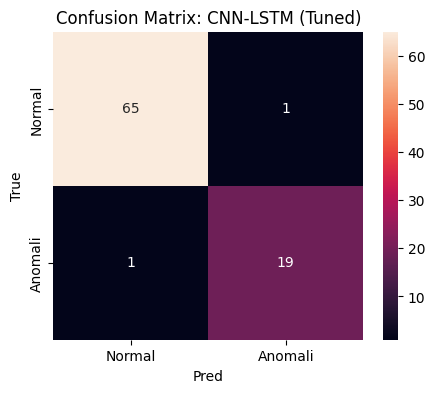

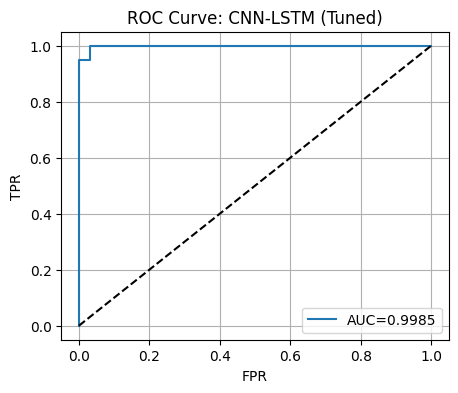

AUC: 0.9984848484848485


In [11]:
best_model = tf.keras.models.load_model(best_trial_file)

y_prob = best_model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("=== CNN-LSTM Evaluation (Tuned) ===")
print(classification_report(y_test, y_pred, target_names=['Normal','Anomali']))
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Normal','Anomali'],
            yticklabels=['Normal','Anomali'])
plt.title("Confusion Matrix: CNN-LSTM (Tuned)")
plt.xlabel("Pred"); plt.ylabel("True")
plt.show()

auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve: CNN-LSTM (Tuned)")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.grid(True)
plt.show()

print("AUC:", auc)


=== Random Forest Baseline ===
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97        66
     Anomali       0.90      0.90      0.90        20

    accuracy                           0.95        86
   macro avg       0.93      0.93      0.93        86
weighted avg       0.95      0.95      0.95        86

Accuracy: 0.9534883720930233


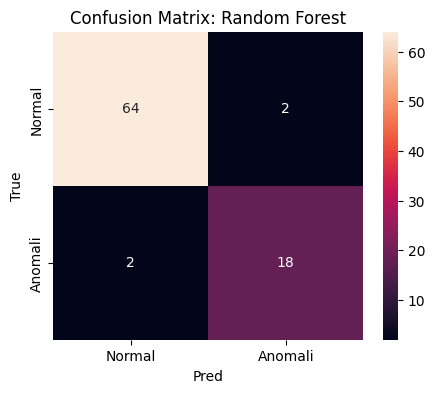

RF AUC: 0.996969696969697


In [14]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], -1)
SEED = np.random.seed(42)
rf = RandomForestClassifier(n_estimators=200, random_state=SEED)
rf.fit(X_train_flat, y_train)

rf_prob = rf.predict_proba(X_test_flat)[:, 1]
rf_pred = (rf_prob > 0.5).astype(int)

print("=== Random Forest Baseline ===")
print(classification_report(y_test, rf_pred, target_names=['Normal','Anomali']))
print("Accuracy:", accuracy_score(y_test, rf_pred))

cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d',
            xticklabels=['Normal','Anomali'],
            yticklabels=['Normal','Anomali'])
plt.title("Confusion Matrix: Random Forest")
plt.xlabel("Pred"); plt.ylabel("True")
plt.show()

print("RF AUC:", roc_auc_score(y_test, rf_prob))


In [4]:
import tensorflow as tf

best_model = tf.keras.models.load_model("best_cnn_lstm.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

# WAJIB untuk LSTM yang menghasilkan TensorList/TensorArray
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Optional: optimisasi (kalau masih error, comment baris ini)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

tflite_path = "NASA_cnn_lstm_.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

print("Saved:", tflite_path)


Saved artifact at '/tmp/tmphltbthm1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 80, 24), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135344353467408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135344353468560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135344353463760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135344353467984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135344353466256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135344353467600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135344353463184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135344353465296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135344353466064: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved: NASA_cnn_lstm_.tflite


In [7]:
import numpy as np
import tensorflow as tf

TFLITE_PATH = "NASA_cnn_lstm_.tflite"

interpreter = tf.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

seq_len = input_details[0]["shape"][1]      # 80
n_feat  = input_details[0]["shape"][2]      # 24
dtype   = input_details[0]["dtype"]

x = np.random.rand(1, seq_len, n_feat).astype(dtype)

# resize untuk batch dinamis (optional tapi aman)
interpreter.resize_tensor_input(input_details[0]["index"], x.shape)
interpreter.allocate_tensors()

interpreter.set_tensor(interpreter.get_input_details()[0]["index"], x)
interpreter.invoke()
y_prob = interpreter.get_tensor(interpreter.get_output_details()[0]["index"]).ravel()

print("Dummy prob:", float(y_prob[0]))
print("Dummy pred:", int(y_prob[0] > 0.5))


Dummy prob: 0.9903628826141357
Dummy pred: 1
